<a href="https://colab.research.google.com/github/HoseinNekouei/sentiment_analysis/blob/main/text_aspect_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [4]:
from datasets import load_dataset

In [5]:
# Standard library imports
import os
import re
import logging
from typing import Optional
from google.colab import output
from google.colab import userdata

# Third-party library imports
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from typing import Optional
from datasets import Dataset

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

userdata.get('HF_TOKEN')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Dataset and Pre-Processing data**

In [88]:
# visualize Data variation
class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.labels.value_counts()
        colors = sns.color_palette('pastel', len(sentiment_count))
        if len(sentiment_count)== 3:
            labels = ['Negative', 'Neutral', 'Positive']
            explode = [0.01, 0.01, 0.01]
        else:
            labels = ['Negative', 'Positive']
            explode = [0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [94]:
class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str, num_classes: int= 3)-> int:
        """ Map class labels to new values."""
        if num_classes == 3:
            sentiment_mapping = {
                'negative': 0,
                'neutral': 1,
                'positive': 2,
            }
        elif num_classes == 2:
            sentiment_mapping = {
                'negative': 0,
                'positive': 1,
            }
        else:
            raise ValueError("num_classes must be 2 or 3.")

        return sentiment_mapping.get(sentiment, -1)

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        contractions = {
            r"won\'t": " will not",
            r"won\'t've": " will not have",
            r"can\'t": " can not",
            r"don\'t": " do not",
            r"didn\'t": " did not",
            r"can\'t've": " can not have",
            r"ma\'am": " madam",
            r"let\'s": " let us",
            r"ain\'t": " am not",
            r"shan\'t": " shall not",
            r"sha\n't": " shall not",
            r"o\'clock": " of the clock",
            r"y\'all": " you all",
            r"n\'t": " not",
            r"n\'t've": " not have",
            r"\'re": " are",
            r"\'s": " is",
            r"\'d": " would",
            r"\'d've": " would have",
            r"\'ll": " will",
            r"\'ll've": " will have",
            r"\'t": " not",
            r"\'ve": " have",
            r"\'m": " am",
            r"\'re": " are",
        }
        for pattern, replacement in contractions.items():
            text = re.sub(pattern, replacement, text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder
        # Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        # Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

In [106]:
class DatasetLoader:
    def __init__(self, *, file_path: str,  nrows= None, _data= None):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = _data
        self.nrows= nrows

    def loader(self) -> pd.DataFrame:
        if self._data is None:
            print("data is available")

            if not os.path.exists(self.file_path):
                logging.error(f"File not found: {self.file_path}")
                raise FileNotFoundError(f"File not found: {self.file_path}")
            try:
                self._data = pd.read_csv(self.file_path, nrows= self.nrows)
                logging.info("Data loaded successfully.")
            except Exception as e:
                logging.error(f"Error loading data: {e}")
                raise

        return self._data

    def visualize_data(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        DataVisualizer.visualize_sentiment(self._data)
        return self._data

    def map_classes(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")
        num_classes= self._data['labels'].value_counts()
        self._data['labels'] = self._data['labels'].apply(TextProcessor.class_mapping, num_classes= num_classes)
        return self._data

    def text_preprocessing(self)-> pd.DataFrame:
        if self._data is None:
            raise ValueError("Data not loaded. Call `loader()` first.")

        # Apply the static method to remove html
        self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)
        # Apply the static method to remove urls
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)
        # Apply the static method to decontract text.
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)
        # Convert texts to lowercase.
        self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())
        # Replace Repeated Characters with a Single Instance
        self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.labels.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self)-> pd.DataFrame:
        self.loader()
        self.visualize_data()
        # self.map_classes()
        self.text_preprocessing()
        return self._data


# **Generate aspect of each text by text2text generation LLM**

In [9]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

class AspectGeneration:
    def __init__(self, save_path, model_name, texts, labels, prompt, batch_size=128):
        self.model_name = model_name
        self.texts = texts
        self.labels= labels
        self.batch_size = batch_size
        self.prompt = prompt
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = None
        self.tokenizer = None
        self.save_path= save_path

    def load_model(self):
        """Load the T5 model and tokenizer."""
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name, device_map='auto', torch_dtype=torch.float16)
        self.tokenizer = T5TokenizerFast.from_pretrained(self.model_name)
        self.model.to(self.device)

    def text_augmentation(self):
        """Generate augmented texts using the T5 model."""
        augmented_texts = []

        for i in range(0, len(self.texts), self.batch_size):
            batch = self.texts[i:i + self.batch_size]
            prompts = [self.prompt + text for text in batch]

            # Tokenize and generate
            inputs = self.tokenizer(
                prompts,
                return_tensors='pt',
                padding=True,
                truncation=True
            ).to(self.device)

            outputs = self.model.generate(
                **inputs,
                max_length=50,
                num_return_sequences=1
            )

            # Decode and combine
            generated_texts = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            print(f'Generated {i}/{len(self.texts)} texts')

            for original_text, generated_text in zip(batch, generated_texts):
                augmented_texts.append(f"{original_text} [START_ASPECT] {generated_text} [END_ASPECT]")

        return augmented_texts

    def create_dataset(self, augmented_texts, labels=None):

        dataset_dict = {"text": augmented_texts}
        if labels is not None:
            dataset_dict["labels"] = self.labels

        # Create a Hugging Face Dataset
        dataset = Dataset.from_dict(dataset_dict)

        # Convert to Pandas DataFrame
        df = pd.DataFrame(dataset_dict)

        # Save to CSV if a save path is provided
        if save_path:
            try:
                df.to_csv(save_path, index=False)
                print(f"Dataset saved successfully to {self.save_path}")
            except Exception as e:
                print(f"Error saving dataset to {self.save_path}: {e}")

        return dataset, df

    def __call__(self):
        self.load_model()
        augmented_texts = self.text_augmentation()

        if self.labels is not None:
            dataset, df = self.create_dataset(augmented_texts, self.labels)  # Pass augmented_texts and labels
            return augmented_texts, dataset, df
        else:
            # Return empty dataset and DataFrame if labels are not provided
            dataset = Dataset.from_dict({"text": augmented_texts})
            df = pd.DataFrame({"text": augmented_texts})
            return augmented_texts, dataset, df

#**Useing File**

In [121]:
from datasets import load_dataset
dataset= load_dataset('stanfordnlp/imdb', split= 'train')
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

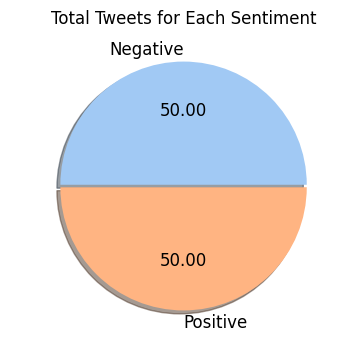

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          25000 non-null  object
 1   labels        25000 non-null  int64 
 2   revised_text  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB
Categories of : {0: 12500, 1: 12500}, 
Information: None


In [126]:
df= dataset.to_pandas()
df= df.rename(columns={'sentence': 'text', 'label': 'labels'})
loader= DatasetLoader(file_path=' ', _data= df)
loader()
print(loader)

In [ ]:
if __name__ == "__main__":
    # !git clone 'https://github.com/HoseinNekouei/sentiment_analysis.git'
    # file_path= '/content/sentiment_analysis/balanced_dataset_US_airline_Tweet.csv'

    # loader= DatasetLoader(file_path= file_path, nrows=100)
    # loader() # Load, visualize, map classes, and preprocess data
    # print(loader)

    batch_size= 512
    model_name = "google/flan-t5-large"
    prompt = "Provide a brief explanation the interpretation of the key emotional aspects and tone: "

    save_path="/content/drive/MyDrive/dataset/aspected_stanfordnlp_IMDB_train_corpus.csv"

    # Initialize the AspectGeneration class
    aspect_generator = AspectGeneration(
        save_path=save_path,
        model_name=model_name,
        texts=loader._data['text'],
        labels=loader._data['lables'],
        prompt=prompt,
        batch_size=batch_size
    )

    # Call the generator
    augmented_texts, dataset, df = aspect_generator()

    # Print results
    print("Augmented Texts:")
    [print(text) for text in augmented_texts[:5]]

    print("\nHugging Face Dataset:")
    print(dataset)

    print("\nPandas DataFrame:")
    print(df.info())

model.safetensors:   1%|1         | 41.9M/3.13G [00:00<?, ?B/s]